# Technical task 1 : Trotterized time-evolution of the Heisenberg Hamiltonian

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile, IBMQ, execute, Aer, QuantumRegister
from qiskit.quantum_info import Pauli, Operator, Statevector
from qiskit.opflow import PauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
import matplotlib.pyplot as plt
import scipy as sp

from qiskit.providers.aer import StatevectorSimulator
backend = StatevectorSimulator()

## Target parameters

In [2]:
# Target evolution time 
T_evol = 2

# Target number of qubits
N_qubits = 4

## Even and odd terms of Heisenberg Hamiltonian

In [3]:
def get_Heisenberg_EO(N_qubits):
    # Return even and odd term of the Heisenberg Hamiltonian on N_qubits spins
        
    def OPauli(s):
        return PauliOp(Pauli(s))
    
    def two_qubit_interaction(i):
        assert i < N_qubits - 1
        return (OPauli("I" * i + "XX" + "I" * (N_qubits - 2 - i)) +
                OPauli("I" * i + "YY" + "I" * (N_qubits - 2 - i)) +
                OPauli("I" * i + "ZZ" + "I" * (N_qubits - 2 - i)))
    
    # Even term
    H_E = sum((two_qubit_interaction(i)
               for i in range(0, N_qubits - 1, 2)))
    # Odd term
    H_O = sum((two_qubit_interaction(i)
               for i in range(1, N_qubits - 1, 2)))
    
    return [H_E, H_O]

## Initial state

In [4]:
def get_circuit_in(N_qubits):
    # Return circuit initializing a state 010101... of N_qubits
    
    circuit_in = QuantumCircuit(N_qubits)
    for i in range(1, N_qubits, 2):
        circuit_in.x(i)
        
    return circuit_in

In [5]:
circuit_in = get_circuit_in(N_qubits)

# Initital state 010101...
psi_in = backend.run(circuit_in).result().get_statevector().data

## Exact evolution

In [6]:
def get_Heisenberg_exact_evol(psi_in, T_evol):
    # Exact evolution of an initial state psi_in for time T_evol under the Heisenberg Hamiltonian
    
    N_qubits = int(np.log2(len(psi_in)))
    
    H1, H2 = get_Heisenberg_EO(N_qubits)
    exactH = H1.to_matrix() + H2.to_matrix()
    
    psi_out = sp.sparse.linalg.expm_multiply(-1j * exactH * T_evol, psi_in)
    
    return psi_out

In [7]:
# Exactly evolved state to compare with the Trotter evolution
psi_evol_exact = get_Heisenberg_exact_evol(psi_in, T_evol)

## Trotter evolution

In [8]:
def get_Heisenberg_trot_circuit(N_qubits, T_evol, trotter_steps, trot_order):
    '''
    Circuit to implement Trotter evolutiomn under the Heisenberg Hamiltonian with single-qubits rotations and CNOT gates
    N_qubits - number of qubits
    T_evol - target evolution timme
    trotter_steps - number of Trotter steps
    trot_order - order of SuzukiTrotter decompositiom, must be even
    '''
    
    assert trotter_steps%2 == 0
    
    # Even and odd terms of the Heisenberg Hamiltonian.
    paulis = get_Heisenberg_EO(N_qubits)

    # Circuit implementing the Trotter evolution with the original pauli terms of the Hamiltonian as the entangling operations
    U_trot_evol = PauliEvolutionGate(paulis, T_evol, synthesis=SuzukiTrotter(order=trot_order, reps=trotter_steps))
    circuit = get_circuit_in(N_qubits)
    circuit.append(U_trot_evol, range(N_qubits))
    
    # Compile and optimize the original circuit for given resource operations
    circuit = transpile(circuit, basis_gates=['rz', 'ry', 'rx', 'cx'], optimization_level=3)
    
    return circuit

def get_evol_trot_state(circuit):
    # Simulate the circuit and get the dense vector of the resulting state
    
    res = backend.run(circuit).result()
    psi_out_trot = res.get_statevector()
    psi_out_trot_dense = psi_out_trot.data
    return psi_out_trot_dense

def get_n_2_qubit_gates(circuit):
    # Number of 2 qubits entangling gates in the circuit
    
    n_2_qubits_gates = sum([ len(inst.qubits) - 1 for inst in circuit.data])

    return n_2_qubits_gates


def estimate_trot_error(T_evol, trotter_steps, trot_order, N_qubits):
    '''
    Estimate of the trotter error:
    
    T_evol - target evolution timme
    trotter_steps - number of Trotter steps
    trot_order - order of SuzukiTrotter decompositiom, must be even
    N_qubits - number of qubits
    '''
        
    delta = T_evol/trotter_steps
    eps = T_evol*delta**trot_order
    
    # For a nearest-neighbor lattice Hamiltonian the estimation can be improved by multiplying with the number of qubits
    eps *= N_qubits
    
    return eps**2

def fidelity_error(psi_1, psi_2):
    # Infidelity between two dense-vector states psi_1 and psi_2
    return 1-np.abs(sum(psi_1*np.conj(psi_2)))**2

## Estimation of the Trotter error and comparison of the Trotter evolution with the exact evolution
We can estimate the optimal value for the Trotter order given the target number of CNOT gates or the circuit depth by minimizing the estimated Trotter error

In [15]:
# We consider two values of the Trotter order to compare: 2 and 4
trot_order_list = [2, 4]

# For each of the Trotter order, we consider some range of Trotter steps
trotter_steps_lists = [range(2,80,4), range(2,20,2)]

# Now we compile the corresponding circuits, compute the number of required CNOT gates and their depth, as well as the estimated Trotter error.
# We also compute the Trotter evolved state and its infidelity with the exactly evolved state.

# Iterate over Trotter Orders
depths_TO = []
n_2_qubit_gates_TO = []
estimate_trot_errors_TO = []
true_trot_error_list_TO = []
for trot_order, trotter_steps in zip(trot_order_list, trotter_steps_lists):
    
    # Iterate over the numbers of Steps
    depths_S = []
    n_2_qubit_gates_S = []
    estimate_trot_errors_S = []
    true_trot_error_list_S = []    
    
    for steps in trotter_steps:
        
        circuit = get_Heisenberg_trot_circuit(N_qubits, T_evol, steps, trot_order)
        
        # Depth
        depths_S += [circuit.depth()]
        # Number of 2-qubit gates
        n_2_qubit_gates_S += [get_n_2_qubit_gates(circuit)]
        
        # Trotter evolved state
        psi_evol_trot = get_evol_trot_state(circuit)
        # Infidelity with the exact state
        true_trot_error_list_S += [fidelity_error(psi_evol_trot, psi_evol_exact)]
        
        # Estimated error
        estimate_trot_errors_S += [estimate_trot_error(T_evol, steps, trot_order, N_qubits)]
        
    depths_TO += [depths_S]
    n_2_qubit_gates_TO += [ n_2_qubit_gates_S ]
    estimate_trot_errors_TO += [ estimate_trot_errors_S ]
    true_trot_error_list_TO += [ true_trot_error_list_S ]

## Example of a circuit: 
qubits: 4, evolution time: 2, Trotter steps 2, Trotter order: 2

Depth = 56, Number of CNOT gates = 24


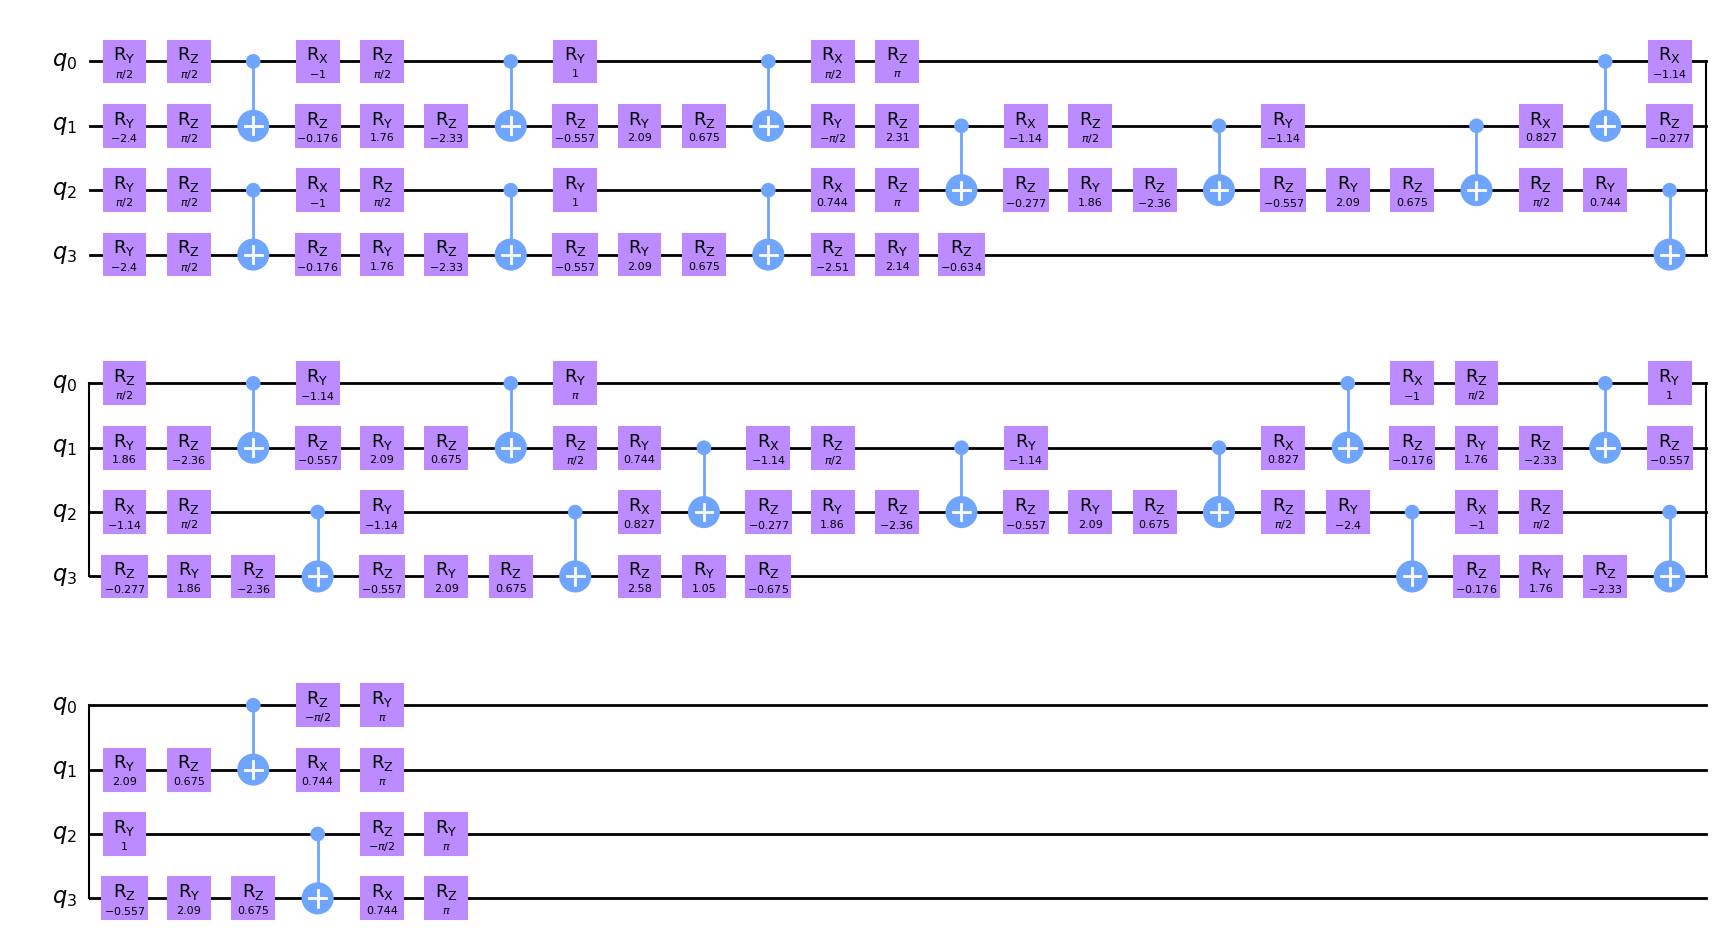

In [12]:
circuit = get_Heisenberg_trot_circuit(N_qubits, T_evol, trotter_steps = 2, trot_order = 2)
print("Depth = %i, Number of CNOT gates = %i" % (circuit.depth(), get_n_2_qubit_gates(circuit)))
circuit.draw('mpl')

## Results
We plot the estimated Trotter error vs the number of required CNOT gates and the circuit depth and compare it with the exact results.
The plot for the estimated error should be interpreted as follows: for a given maximum number of CNOT gates or the circuit depth, one should choose the Trotter order and the number of the Trotter steps, which gives the smallest estimated error.

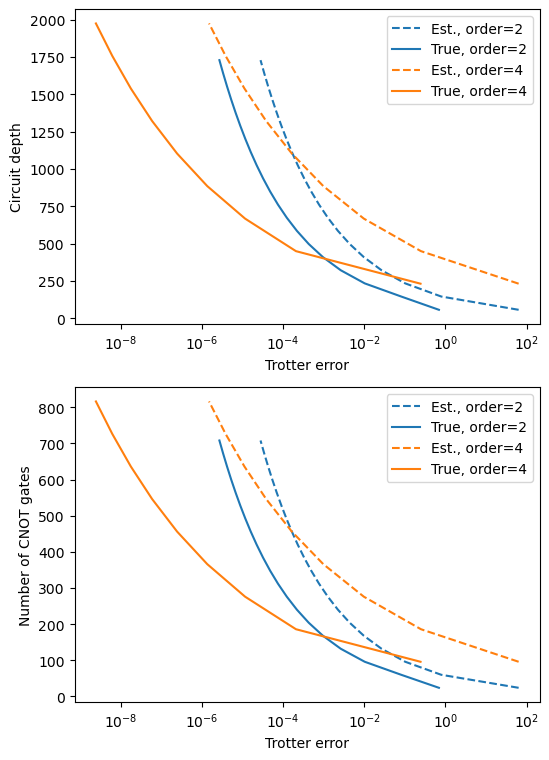

In [16]:
_, ax_list = plt.subplots(2,1, figsize = (6, 9))

for i, trot_order in enumerate(trot_order_list):
    
    depths_S = depths_TO[i]
    n_2_qubit_gates_S = n_2_qubit_gates_TO[i]
    estimate_trot_errors_S = estimate_trot_errors_TO[i]
    true_trot_error_list_S = true_trot_error_list_TO[i]
    
    ax = ax_list[0]
    ax.semilogx(estimate_trot_errors_S, depths_S, color = 'C'+str(i), label = "Est., order=" + str(trot_order), linestyle = "--")
    ax.semilogx(true_trot_error_list_S, depths_S, color = 'C'+str(i), label = "True, order=" + str(trot_order))
    
    ax = ax_list[1]
    ax.semilogx(estimate_trot_errors_S, n_2_qubit_gates_S, color = 'C'+str(i), label = "Est., order=" + str(trot_order), linestyle = "--")
    ax.semilogx(true_trot_error_list_S, n_2_qubit_gates_S, color = 'C'+str(i), label = "True, order=" + str(trot_order))
    
ax = ax_list[0]
ax.set_ylabel("Circuit depth")
ax.set_xlabel("Trotter error")
ax.legend()

ax = ax_list[1]
ax.set_ylabel("Number of CNOT gates")
ax.set_xlabel("Trotter error")
ax.legend()